# Experimenting with Cross-Validation Using team_id

In [28]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

DATA_PROCESSED = Path("../data/processed/hr_attrition_clean.csv")
df = pd.read_csv(DATA_PROCESSED)

TARGET_COL = "attrited"
GROUP_COL  = "team_id"   # group boundary for CV
assert TARGET_COL in df.columns and GROUP_COL in df.columns

In [29]:
drop_cols = [
    "employee_id",
    "exit_interview_scheduled",
    "offboarding_ticket_created",
    "months_since_hire",
    "salary_band",            # keeping base_salary as canonical comp signal
    GROUP_COL                 # exclude from features, used only as groups
]

df_model = df

In [30]:
# I want to test whether high workload combined with poor manager performance can strongly influence attrition

# Create a binary flag to show if there's a suspected poor manager and high workload for an employee (for stakeholder insights)
def make_mgmt_workload_risk(df, mq_col="manager_quality", wl_col="workload_score"):
    mq = df[mq_col]
    wl = df[wl_col]

    df["mgmt_workload_risk"] = (
        (mq.isna()) |
        ((mq < 5) & (wl > 7))
    ).astype(int)

    return df

df_model = make_mgmt_workload_risk(df_model)
df_model.head()

,employee_id,snapshot_date,hire_date,region,department,role,level,is_manager,age,gender,...,team_id,exit_interview_scheduled,offboarding_ticket_created,attrited,months_since_hire,salary_band,commute_zero,internal_moves_flag,stock_grants_flag,mgmt_workload_risk
0,121752,2020-05-13,2014-08-10,amer,sales,sales manager,ic3,0,33,f,...,85,0,0,0,69.1,q4,0,0,0,0
1,107208,2020-09-20,2011-07-14,apac,engineering,swe ii,manager,1,31,f,...,6,0,0,0,110.2,q5,0,0,1,0
2,117058,2020-12-29,2013-07-28,emea,sales,ae,ic2,0,40,m,...,177,0,0,0,89.1,q3,0,1,0,0
3,120754,2023-10-31,2012-04-06,amer,engineering,ml engineer,ic4,0,26,m,...,232,0,0,0,138.8,q4,1,0,1,0
4,122505,2022-07-20,2015-05-25,apac,hr,hrbp,ic3,0,31,f,...,328,1,0,1,85.8,q3,0,0,0,0


In [31]:
# Create a continuous column for poor manager/high workload risk to assist with model predictive power

def make_mgmt_workload_score(df, mq_col="manager_quality", wl_col="workload_score"):
    mq = df[mq_col]
    wl = df[wl_col]

    scaler = MinMaxScaler()
    df["mgmt_workload_score"] = scaler.fit_transform(
        (10 - mq + wl).to_numpy().reshape(-1, 1)
    )

    return df

df_model = make_mgmt_workload_score(df_model)
df_model.head()

,employee_id,snapshot_date,hire_date,region,department,role,level,is_manager,age,gender,...,exit_interview_scheduled,offboarding_ticket_created,attrited,months_since_hire,salary_band,commute_zero,internal_moves_flag,stock_grants_flag,mgmt_workload_risk,mgmt_workload_score
0,121752,2020-05-13,2014-08-10,amer,sales,sales manager,ic3,0,33,f,...,0,0,0,69.1,q4,0,0,0,0,0.476162
1,107208,2020-09-20,2011-07-14,apac,engineering,swe ii,manager,1,31,f,...,0,0,0,110.2,q5,0,0,1,0,0.466031
2,117058,2020-12-29,2013-07-28,emea,sales,ae,ic2,0,40,m,...,0,0,0,89.1,q3,0,1,0,0,0.432062
3,120754,2023-10-31,2012-04-06,amer,engineering,ml engineer,ic4,0,26,m,...,0,0,0,138.8,q4,1,0,1,0,0.651371
4,122505,2022-07-20,2015-05-25,apac,hr,hrbp,ic3,0,31,f,...,1,0,1,85.8,q3,0,0,0,0,0.451728


In [32]:
# Domain + multicollinearity-driven drops
drop_vif_cols = [
    "compa_ratio",         # very high collinearity with salary
    "avg_raise_3y",        # overlaps with compa_ratio & salary
    "benefit_score",       # collinear with engagement_score
    "manager_quality",     # redundant with the addition of mgmt_workload_score
    "workload_score"       # redundant with the addition of mgmt_workload_score
    "stock_grants"         # retaining stock grants flag
    "age",                 # overlaps with tenure_years
    "internal_moves_last_2y",  # redundant with internal_moves_flag
    "mgmt_workload_risk",
    "stock_grants"   # redundant as retaining the continuous score 
]

drop_cols = [c for c in (drop_cols + drop_vif_cols) if c in df.columns]
df_model = df_model.drop(columns=drop_cols)

X = df_model.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype(int)
groups = df[GROUP_COL]  # from original df before drop

In [33]:
print(X.columns)

Index(['snapshot_date', 'hire_date', 'region', 'department', 'role', 'level',
       'is_manager', 'age', 'gender', 'remote_status', 'commute_km',
       'tenure_years', 'base_salary', 'time_since_last_promo_yrs',
       'performance_rating', 'engagement_score', 'workload_score',
       'learning_hours_last_yr', 'overtime_hours_month', 'night_shift',
       'schedule_flex', 'sick_days', 'pto_days_taken', 'leave_last_yr',
       'commute_zero', 'internal_moves_flag', 'stock_grants_flag',
       'mgmt_workload_score'],
      dtype='object')


In [34]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=False))
])
categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

In [35]:
selector = SelectFromModel(
    RandomForestClassifier(n_estimators=250, random_state=42, n_jobs=-1),
    threshold="median",
    prefit=False
)

pipe_lr = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("select", selector),
    ("clf", LogisticRegression(max_iter=1000))
])

pipe_rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("select", selector),
    ("clf", RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1))
])
models = {"LogReg+SelectFromModel": pipe_lr, "RF+SelectFromModel": pipe_rf}

In [ ]:
# Use K-fold cross-validation to account for groupings in team_id
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

def eval_grouped_cv(model, X, y, groups, name):
    aucs, ap_scores = [], []
    rocs, prs = [], []
    fold = 0
    for train_idx, val_idx in cv.split(X, y, groups):
        fold += 1
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_tr, y_tr)
        proba = model.predict_proba(X_val)[:, 1]
        pred  = (proba >= 0.5).astype(int)

        auc  = roc_auc_score(y_val, proba)
        ap   = average_precision_score(y_val, proba)
        fpr, tpr, _ = roc_curve(y_val, proba)
        prec, rec, _ = precision_recall_curve(y_val, proba)

        aucs.append(auc); ap_scores.append(ap)
        rocs.append((fpr, tpr)); prs.append((prec, rec))

        print(f"[{name}] Fold {fold}: AUC={auc:.3f} | AP={ap:.3f}")

    print(f"\n[{name}] Mean AUC={np.mean(aucs):.3f} ± {np.std(aucs):.3f} | "
          f"Mean AP={np.mean(ap_scores):.3f} ± {np.std(ap_scores):.3f}")
    return {"aucs":aucs, "aps":ap_scores, "rocs":rocs, "prs":prs}

results = {}
for name, mdl in models.items():
    results[name] = eval_grouped_cv(mdl, X, y, groups, name)

[LogReg+SelectFromModel] Fold 1: AUC=0.652 | AP=0.269
[LogReg+SelectFromModel] Fold 2: AUC=0.641 | AP=0.237


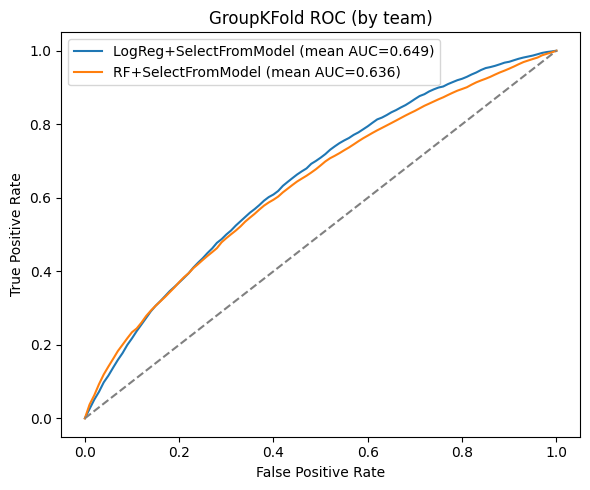

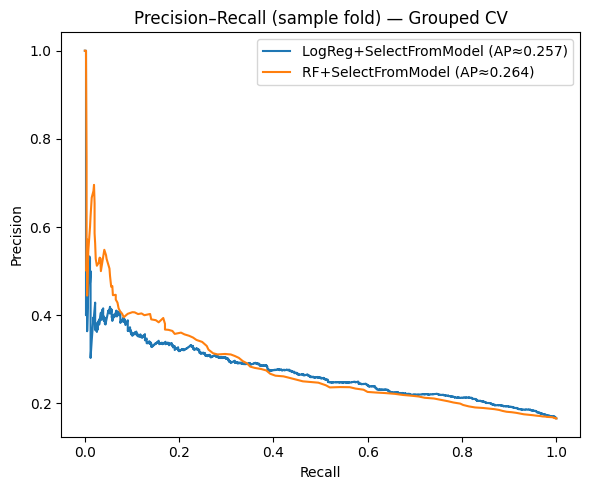

In [ ]:
plt.figure(figsize=(6,5))
for name, res in results.items():
    # simple average curve (not perfectly calibrated but good for viz)
    mean_fpr = np.linspace(0,1,101)
    tprs = []
    for fpr, tpr in res["rocs"]:
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)
    mean_tpr = np.mean(tprs, axis=0)
    plt.plot(mean_fpr, mean_tpr, label=f"{name} (mean AUC={np.mean(res['aucs']):.3f})")
plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("GroupKFold ROC (by team)")
plt.legend(); plt.tight_layout()
plt.savefig("../reports/ROCcomparisonCV")
plt.show()

plt.figure(figsize=(6,5))
for name, res in results.items():
    # average PR curve (rough)
    # concatenate then sort by recall is messy; we’ll just plot first fold as example
    prec, rec = results[name]["prs"][0]
    plt.plot(rec, prec, label=f"{name} (AP≈{np.mean(results[name]['aps']):.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall (sample fold) — Grouped CV")
plt.legend(); plt.tight_layout()
plt.savefig("../reports/Precision-RecallCV")
plt.show()

In [ ]:
winner_name = max(results.keys(), key=lambda n: np.mean(results[n]["aucs"]))
winner_pipe = models[winner_name]
print("Selected model:", winner_name)

winner_pipe.fit(X, y)

from joblib import dump
Path("../models").mkdir(exist_ok=True, parents=True)
dump(winner_pipe, "../models/attrition_model_groupcv.pkl")
print("Saved: ../models/attrition_model_groupcv.pkl")

Selected model: LogReg+SelectFromModel
Saved: ../models/attrition_model_groupcv.pkl
